### Función objetivo :

$$Min(\lambda * \sigma^2 - (1 - \lambda) * R)$$

- $R$ retorno del portafolio

- $\sigma^2$ riesgo del portafolio

- $\lambda$ es que tanto riesgo queremos asumir ( $\lambda \in$ \[0, 1\] )

Veamos que si lambda es 1 pasamos a minimizar el riesgo del portafolio y si lambda es 0 passamos a maximizar el retorno portafolio.

In [132]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

In [133]:

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]  # Activos del portafolio
start_date = "2015-01-01"

In [134]:
# Descargar precios de cierre históricos
data = yf.download(tickers, start=start_date)["Close"]

[*********************100%***********************]  5 of 5 completed


In [135]:

returns = data.pct_change().dropna()  # Retornos diarios

# Calcular rendimientos esperados y matriz de covarianza
# Se multiplica por 252 para llevar a un promidio y covarianza anual 
# Dato : los días hábiles de precios en el año son 252 (muestran los precios de los activos 252 días en el año)
mu = returns.mean().values * 252  # Rendimientos esperados anuales
Sigma = returns.cov().values * 252  # Matriz de covarianza anualizada

# Parámetro de riesgo-retorno
lambda_ = 0.7  # Ajusta entre 0 y 1 para cambiar la tolerancia al riesgo 
#Un mayor lambda implica priorizar el riesgo y un menor lambda priorizar un mayor retorno

# Variables de decisión
n_assets = len(tickers)
w = cp.Variable(n_assets)

# Función objetivo
objective = cp.Minimize(lambda_ * cp.quad_form(w, Sigma) - (1 - lambda_) * mu @ w)

# Restricciones
constraints = [ cp.sum(w) == 1, w >= 0 ]

# Resolver el problema con cvxpy
problem = cp.Problem(objective, constraints)
problem.solve()

0.060624623841397066

In [136]:
# Resultados
if problem.status == cp.OPTIMAL:
    optimal_weights = w.value
    portfolio_return = mu @ optimal_weights
    portfolio_risk = np.sqrt(optimal_weights.T @ Sigma @ optimal_weights)
    optimal_weights_percent = optimal_weights * 100
    portfolio_table = pd.DataFrame({
        "Ticker": tickers,
        "Peso (%)": optimal_weights_percent
    })
    portfolio_table["Peso (%)"] = portfolio_table["Peso (%)"].round(0)
    display(portfolio_table)
    print(f"Retorno esperado: {(portfolio_return*100).round(0)} %")
    print(f"Riesgo (desviación estándar): {(portfolio_risk*100).round(0)} %")
else:
    print("No se encontró una solución óptima.")

,Ticker,Peso (%)
0,AAPL,32.0
1,MSFT,8.0
2,GOOGL,28.0
3,AMZN,32.0
4,TSLA,0.0


Retorno esperado: 27.0 %
Riesgo (desviación estándar): 25.0 %


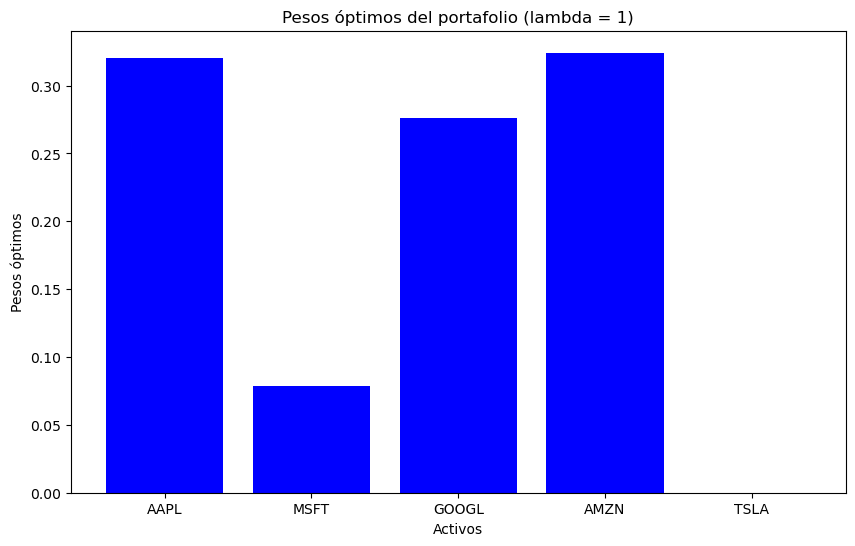

In [137]:
#Gráfico de inversión
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color='blue')
plt.xlabel("Activos")
plt.ylabel("Pesos óptimos")
plt.title(f"Pesos óptimos del portafolio (lambda = {lambda_})")
plt.show()